In [1]:
from scipy.sparse import csgraph
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [2]:
df =pd.read_csv('shuttle-unsupervised-ad.tab', sep='\t', header =None)

In [3]:
data = df.iloc[:,0:9]

In [4]:
x = data.values

In [5]:
def laplace_graph(data,n_neighbors):
    
    data_size = x.shape[0]
    knn_dist_graph = kneighbors_graph(X=x,
                                 n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric='euclidean',
                                 n_jobs=6)
    
    sigma = 1
    similarity_graph = sparse.lil_matrix(knn_dist_graph.shape)
    nonzeroindices = knn_dist_graph.nonzero()
    similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
    similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
    degree_matrix = similarity_graph.sum(axis=1)
    diagonal_matrix = np.diag(np.asarray(degree_matrix).reshape(data_size,))
    L =  diagonal_matrix - similarity_graph
    return L
    
    
    

In [6]:
n = 4
L= laplace_graph(x,n)

In [7]:
L

matrix([[2.54732439e-03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.85091197e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.06866192e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.15364282e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.78929508e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.19387377e+00]])

In [8]:
class elm:
    def __init__(self, input_data, nh,lamba2):
        self.input = input_data
        self.hidden_neurons= nh
        self.lambda2 = lamba2
        self.wr = np.random.rand(self.input.shape[1], self.hidden_neurons)
        self.br = np.random.rand(1, self.hidden_neurons)
        
    def sigmoid(self,x):
        return (1 / (1 + np.exp(-x)))
    
    def compute_H(self):
        H_ops = np.matmul(np.transpose(self.wr), np.transpose(self.input)) + np.transpose(self.br)
        H_ops = self.sigmoid(H_ops)
        H_ops = np.transpose(H_ops)
        return H_ops
    
    def w_star(self, H):
        a = np.linalg.inv(np.matmul(np.transpose(H), H) + self.lambda2*np.identity(self.hidden_neurons))
        b = np.matmul(np.transpose(H), self.input)
        Wx = np.matmul(a, b)
        return Wx

    def predict(self):
        wr = self.wr; br = self.br
        H = self.compute_H()
        Wx = self.w_star(H)
        a = np.matmul(np.transpose(wr), np.transpose(self.input))
        b = np.transpose(br); c = self.sigmoid(a + b)
        recons = np.matmul(np.transpose(Wx), c)
        return np.transpose(recons)

In [9]:
nh =100
lambda2 = 0.1
N= x.shape[0]

In [10]:
model = elm(x,nh,lambda2)

In [11]:
H= model.compute_H()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [12]:
Ih = np.identity(nh)
Iu = np.identity(N)
lamda = 2


In [13]:
if nh <= N:
    A= Ih+ lamda* np.matmul(np.transpose(H),np.matmul(L,H))
    B= np.matmul(np.transpose(H),H)
    r,v = np.linalg.eig(A)
    arr1inds = r.argsort()
    v1 = v.copy()
    v2 = v1[arr1inds]
    v3 = v2[:,1:]
    vec1 = np.matmul(H,v)
    vec_norm1 = np.linalg.norm(vec1) 
    vi= v3 /vec_norm1
    W = vi
    print('weight calculated for nh<=N sample data ...')
    
else:
    
    A= Iu+ lamda* np.matmul(L,np.matmul(H,H.T))
    B= np.matmul(np.transpose(H),H)
    r,u = np.linalg.eig(A)
    arr1inds = r.argsort()
    u1 = u.copy()
    u2= u1[arr1inds]
    u3 = u2[:,1:]
    vec2 =np.matmul(H, np.matmul(H.T,u))
    vec_norm2 = np.linalg.norm(vec2)
    ui= u3/vec_norm2
    W= np.matmul(H.T,u)
    print('weight calculated for sparse sample data ...')

weight calculated for nh<=N sample data ...


In [14]:
"embedding matrix"

E = np.matmul(H,W)

In [15]:
E.shape

(46464, 99)

In [16]:
np.set_printoptions(precision=3)

In [17]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(E[:,1])

In [18]:
y= pd.DataFrame(y_km)

In [19]:
anomaly_index = np.where(y_km==1)

In [21]:
df_subset = data.loc[anomaly_index,3]

In [22]:
df_subset

219        -8.0
279        40.0
405         0.0
532      -587.0
567      -674.0
645         3.0
694        -1.0
720        -4.0
856        -6.0
1302       -2.0
3315       -1.0
3516        0.0
6608        0.0
6897        0.0
6969      -29.0
8736       -2.0
9715        0.0
12370      -2.0
13915      -6.0
13948     -57.0
14085       0.0
14182   -3939.0
15840       0.0
15919       0.0
20433      -1.0
20759       0.0
22859       0.0
23397       0.0
23516       0.0
24463    -133.0
25898       0.0
27304    -230.0
27677      -1.0
28909       0.0
30150      -1.0
30228    -478.0
30607       0.0
34221     -23.0
34542    -495.0
35408      -1.0
36096      -2.0
36570     -72.0
37070      -2.0
37777    -318.0
38328       0.0
38404   -1108.0
39337       0.0
42337     -37.0
43766       0.0
45168       0.0
46298    -222.0
Name: 3, dtype: float64

In [23]:
new = df.iloc[:,9].str.contains('o',regex=False)

In [24]:
real_anomaly_idx = new.where(new==True).dropna().index

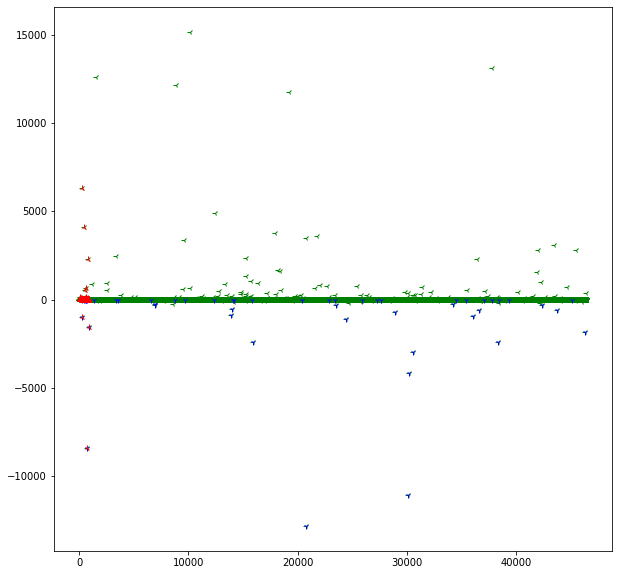

In [30]:
figure = plt.figure(figsize= [10,10])
df_dtect = data.loc[anomaly_index,5]
df_anomaly=data.loc[real_anomaly_idx,5]
df_data = data.iloc[:,5]
plt.plot(df_data, 'g3')
plt.plot(df_dtect, 'b1')
plt.plot(df_anomaly, 'r2')



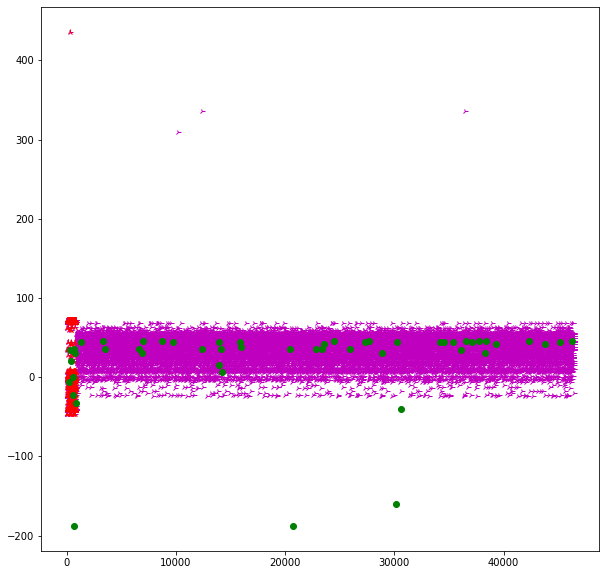

In [41]:
figure = plt.figure(figsize= [10,10])
df_subset = data.loc[anomaly_index,4]
df_anomaly=data.loc[real_anomaly_idx,4]
df_data = data.iloc[:,4]
plt.plot(df_data,'4m')
plt.plot(df_anomaly, 'r2')
plt.plot(df_subset, 'go')

